车牌图像检测

In [21]:
import cv2
import os
import os.path
import math
import random
import sys
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

In [22]:
def imshow(img):
    s=img.shape
    if len(s)>2:
        b,g,r=cv2.split(img)
        img=cv2.merge([r,g,b])
    else:
        img=cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    plt.imshow(img)
    plt.show()

In [23]:
conv=nn.Sequential(
            nn.Conv2d(1,64,kernel_size=3,padding=1), #layer1, inputs single channel,256*128
            nn.ReLU(inplace=True),
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(64,128,kernel_size=3,padding=1), #layer2 inputs 64 channel,128*64
            nn.ReLU(inplace=True),
            nn.Conv2d(128,128,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(128,256,kernel_size=3,padding=1), #layer3 inputs 128 channel,64*32
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(256,512,kernel_size=3,padding=1), #layer4 inputs 256 channel,32*16
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(512,512,kernel_size=3,padding=1), #layer5 inputs 512 channel,16*8
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2)
    )

class vgg16train(nn.Module):
    def __init__(self):
        super(vgg16train,self).__init__()
        self.features=conv
        self.classifier=nn.Sequential(
            nn.Dropout(),
            #nn.Linear(512 *3* 8 * 4, 4096),                             #connect: layter: inputs 512, 8*4
            nn.Linear(512 * 8 * 4, 4096),                             #connect: layter: inputs 512, 8*4
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 2048),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(2048, 2)
        )
        #initialize_weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()
    def forward(self,x):
        x=self.features(x)
        x=x.view(x.size(0),-1)
        x=self.classifier(x)
        return x    

In [24]:
net=vgg16train()
net.load_state_dict(torch.load('/home/wang/git/anpr/plate.weight'))
net.cuda()
print('over')

over


In [25]:
#{'plate': 1, 'back': 0}
classesc=['back','plate']
data_transform=transforms.Compose([transforms.ToTensor(),
                                   #transforms.RandomHorizontalFlip(),
                                   transforms.Normalize((107.5051,), (3847.1679,)),
                                   ])

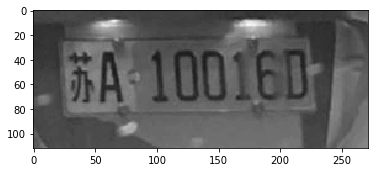

(112, 272)


In [26]:
TESTFILE='/home/wang/git/nppic/newenergy0510.png'
im=cv2.imread(TESTFILE)
im=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
imshow(im)
print im.shape

img=np.ndarray((1,128,256),np.uint8)
img[0]=cv2.resize(im,(256,128))
datas=data_transform(img)
datas=torch.unsqueeze(datas,1)
datas.size()

datas_var=torch.autograd.Variable(datas)
datas_var=datas_var.cuda()
outputs_var=net(datas_var)
print('over')

_,pred=torch.max(outputs_var,1)
print pred
p=pred.cpu().data.numpy()
p=np.squeeze(p)
print classesc[p]

torch.Size([1, 1, 128, 256])

over


Variable containing:
 0
[torch.cuda.LongTensor of size 1x1 (GPU 0)]

back
